<a href="https://colab.research.google.com/github/stevearonson/VB-Video-Tracking/blob/master/Detectron2%20with%20DeepSort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 27kB/s 
     |████████████████████████████████| 6.6MB 36.6MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 779kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200711-cp36-none-any.whl size=42285 sha256=a20b06067afa1d8048d8eb03fe1f3ce13c6ff9f8905a9680fb2e58c22e8afd16
  Stored in directory: /root/.cache/pip/wheels/be/e2/ff/183aa84c45c7f0a6f55d2a40bdbfc00e9d5c36b492065ec526
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
from tqdm import tqdm 
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!ls /gdrive/'My Drive'/'VB/Video'

 Cheshire_Halasz_Perin.pdf   court-diagram-vertical.jpg   panopt.mp4
 Cheshire_Halasz_Perin.zip  'MBVF M7 S3.mp4'		  people.mp4
 court-diagram.jpg	     OpenCV.ipynb


Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:16, 10.9MB/s]                           


### drawPlayers
Convert predictions into player positions
Draws circles at players feet

In [ ]:
from shapely.geometry import Point, Polygon


def drawPlayers(im, instances, frame_no):

  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 1
  color = [255, 0, 0]   
  thickness = 2
  radius = 10

  pred_boxes = instances.get('pred_boxes')
  pred_classes = instances.get('pred_classes')
  
  positions = []
  for ix, box in enumerate(pred_boxes):
    
    # Include only class Person
    if pred_classes[ix] == 0:  

      xcenter = int((box[0] + box[2]) / 2)
      ylower = int(box[3])
      player_pos = (xcenter, ylower)

      
      # Draw only players that are within the basketball court
      if Point(player_pos).within(video_playing):
        cv2.circle(im, player_pos, radius, color, thickness)
        #cv2.putText(im, str(ix), player_pos, font, fontScale, color, 
        #            thickness, cv2.LINE_AA)
        positions.append({'Frame' : frame_no, 'ID' : ix, 'X': xcenter, 'Y' : ylower})

  return positions
  

In [ ]:
def createMiniMap(court, positions, M):
  court_diagram = court.copy()

  # player marker parameters
  radius = 10
  color = [255, 0, 0]   
  thickness = 2

  # convert video positions to court diagram positions
  df = pd.DataFrame(positions)
  src_pts = np.array([df[['X', 'Y']].astype('float32').values])
  # print(src_pts, src_pts.shape, src_pts.dtype)
  dst_pts = cv2.perspectiveTransform(src_pts, M)
  # print(dst_pts)

  for pt in dst_pts.squeeze().astype('int'):
    cv2.circle(court_diagram, tuple(pt), radius, color, thickness)

  miniMap = cv2.resize(court_diagram, (250, 400), interpolation = cv2.INTER_AREA)

  return miniMap


In [ ]:
video_court = np.array([[[467, 249], [781, 242], [1274, 588], [630, 656], [3, 619]]])
video_playing = Polygon(np.array([[426, 235], [824, 230], [1272, 512], [1253, 714], [9, 713], [15, 470]]))

diagram_court = np.array([[[100, 100], [400, 100], [400, 700], [250, 700], [100, 700]]])

M, status = cv2.findHomography(video_court, diagram_court)
print(video_court.shape, diagram_court.shape, M)

(1, 5, 2) (1, 5, 2) [[-8.13760107e-01 -1.71624918e+00  7.27248394e+02]
 [-1.38555041e-01 -6.17360827e+00  1.52113806e+03]
 [-1.53537252e-04 -6.97341772e-03  1.00000000e+00]]


In [ ]:
# create a time log for rallys in video
time_log = pd.DataFrame({'Rally': [1,2,3,4], 
                         'Start': pd.to_timedelta(['00:00:11', '00:00:33', '00:00:52','00:01:18']),
                         'Length': pd.to_timedelta(['00:00:06', '00:00:08', '00:00:14','00:00:11'])
                         })

In [ ]:
# v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

cap = cv2.VideoCapture('/gdrive/My Drive/VB/Video/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

court_diagram = cv2.imread('/gdrive/My Drive/VB/Video/court-diagram-vertical.jpg')

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter('/gdrive/My Drive/VB/Video/people.mp4', fourcc,
                           frames_per_second, (width, height))

video_time = 0
all_pos = []

for _,rally in time_log.iterrows():
  # skip to beginning of rally
  skip_frames = int((rally['Start'].seconds - video_time) * frames_per_second)
  for ix in range(skip_frames):
    ret, frame = cap.read()
    videoOut.write(frame)
  video_time = rally['Start'].seconds

  rally_frames = int(rally['Length'].seconds * frames_per_second)
  for ix in tqdm(range(rally_frames)):
    ret, frame = cap.read()
    outputs = predictor(frame)

    # add the court outline
    frame_poly = cv2.polylines(frame, [video_court], isClosed=True, color=[255,0,0], thickness=2)

    # add player locations
    player_pos = drawPlayers(frame_poly, outputs['instances'], ix)
    all_pos.extend(player_pos)

    # create mini map with player positions
    miniMap = createMiniMap(court_diagram, player_pos, M)
    (w,h,c) = miniMap.shape

    #insert mini map into frame
    frame_poly[0:w, 0:h, :] = miniMap
    
    videoOut.write(frame_poly)
    
  video_time += rally['Length'].seconds

    # visualization = v.draw_instance_predictions(frame_poly, outputs["instances"].to("cpu"))
    # visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
    # videoOut.write(visualization)

videoOut.release()
cap.release()

print(all_pos)

100%|██████████| 309/309 [02:21<00:00,  2.18it/s]

[{'Frame': 0, 'ID': 0, 'X': 591, 'Y': 500}, {'Frame': 0, 'ID': 1, 'X': 1050, 'Y': 491}, {'Frame': 0, 'ID': 2, 'X': 861, 'Y': 476}, {'Frame': 0, 'ID': 3, 'X': 345, 'Y': 477}, {'Frame': 0, 'ID': 4, 'X': 488, 'Y': 330}, {'Frame': 0, 'ID': 5, 'X': 708, 'Y': 316}, {'Frame': 0, 'ID': 6, 'X': 762, 'Y': 280}, {'Frame': 0, 'ID': 16, 'X': 666, 'Y': 311}, {'Frame': 0, 'ID': 23, 'X': 640, 'Y': 315}, {'Frame': 0, 'ID': 24, 'X': 810, 'Y': 239}, {'Frame': 0, 'ID': 25, 'X': 506, 'Y': 236}, {'Frame': 1, 'ID': 0, 'X': 588, 'Y': 498}, {'Frame': 1, 'ID': 1, 'X': 1050, 'Y': 491}, {'Frame': 1, 'ID': 2, 'X': 861, 'Y': 476}, {'Frame': 1, 'ID': 3, 'X': 344, 'Y': 478}, {'Frame': 1, 'ID': 4, 'X': 488, 'Y': 330}, {'Frame': 1, 'ID': 5, 'X': 708, 'Y': 316}, {'Frame': 1, 'ID': 6, 'X': 760, 'Y': 279}, {'Frame': 1, 'ID': 16, 'X': 666, 'Y': 312}, {'Frame': 1, 'ID': 21, 'X': 641, 'Y': 315}, {'Frame': 1, 'ID': 24, 'X': 506, 'Y': 236}, {'Frame': 2, 'ID': 0, 'X': 588, 'Y': 498}, {'Frame': 2, 'ID': 1, 'X': 1050, 'Y': 491}, 

In [ ]:
rally['Length'].seconds

11

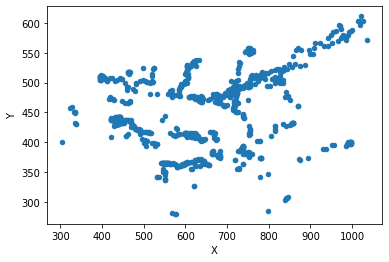

In [ ]:
df = pd.DataFrame(all_pos)
df[df['ID'] == 0].plot('X','Y',kind='scatter')

In [ ]:
src_pts = np.array([df[['X', 'Y']].astype('float32').values])
dst_pts = cv2.perspectiveTransform(src_pts, M).squeeze()

In [ ]:
df[['TX', 'TY']] = pd.DataFrame(dst_pts, columns=['TX', 'TY'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Frame   1610 non-null   int64  
 1   ID      1610 non-null   int64  
 2   X       1610 non-null   int64  
 3   Y       1610 non-null   int64  
 4   TX      1610 non-null   float32
 5   TY      1610 non-null   float32
dtypes: float32(2), int64(4)
memory usage: 63.0 KB


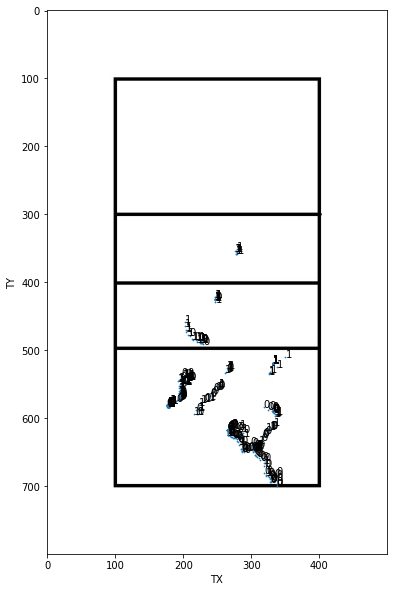

In [ ]:
import matplotlib.pyplot as plt

court_diagram = cv2.imread('/gdrive/My Drive/VB/Video/court-diagram-vertical.jpg')

def annotate_df(row):  
  ax.text(row['TX'], row['TY'], row['ID'].astype('int'))

ax = df[df['ID'].isin([0,1])].plot(x='TX', y='TY', kind='scatter', s=0.5, figsize=(16,10))
_ = df[df['ID'].isin([0,1])].apply(annotate_df, axis=1)
plt.imshow(court_diagram)

In [ ]:
outputs['instances']

Instances(num_instances=27, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[7.8184e+02, 2.5586e+02, 8.4883e+02, 4.2799e+02],
        [6.4005e+02, 2.4984e+02, 6.9651e+02, 3.8234e+02],
        [5.6266e+02, 2.1371e+02, 6.2189e+02, 3.6343e+02],
        [5.2819e+02, 1.9973e+02, 5.5752e+02, 2.8179e+02],
        [1.1881e+03, 3.3310e+02, 1.2784e+03, 4.2718e+02],
        [7.7022e+02, 2.3636e+02, 8.2021e+02, 3.5670e+02],
        [1.1338e+03, 2.9286e+02, 1.2306e+03, 3.9108e+02],
        [7.0849e+02, 2.2107e+02, 7.3770e+02, 3.3216e+02],
        [1.0104e+03, 2.1551e+02, 1.0403e+03, 3.2154e+02],
        [1.1221e-01, 3.3781e+02, 6.0422e+01, 4.5910e+02],
        [4.7108e+01, 2.5764e+02, 8.8852e+01, 3.4025e+02],
        [1.0592e+03, 2.5751e+02, 1.1170e+03, 3.6032e+02],
        [2.6886e+02, 1.5441e+02, 3.0542e+02, 2.6196e+02],
        [4.6627e+02, 1.9803e+02, 4.8447e+02, 2.3642e+02],
        [1.1748e+02, 2.9858e+02, 1.7279e+02, 3.8695e+02],
        [9.7366e+02, 2.0515e+02, 1.0072e

Court Identification

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
!ffmpeg -i "/gdrive/My Drive/VB/Video/MBVF M7 S3.mp4" -t 00:00:06 -c:v copy video-clip.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
!git clone https://github.com/facebookresearch/detectron2
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

fatal: destination path 'detectron2' already exists and is not an empty directory.
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Failed to load OpenCL runtime
[07/09 16:21:35 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='video-output.mkv', video_input='video-clip.mp4', webcam=False)
[07/09 16:21:39 fvcore.common.checkpoint]: Loading c

In [ ]:
panopt = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
panopt.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
panopt.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
panopt.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
panopt_pred = DefaultPredictor(panopt)

model_final_cafdb1.pkl: 261MB [00:26, 9.99MB/s]                           


In [ ]:
v = VideoVisualizer(MetadataCatalog.get(panopt.DATASETS.TRAIN[0]), ColorMode.IMAGE)

cap = cv2.VideoCapture('/gdrive/My Drive/Colab Notebooks/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter('/gdrive/My Drive/Colab Notebooks/panopt.mp4', fourcc, 20.0, 
                           (width,height))



for ix in tqdm(range(int(1 * frames_per_second))):
  ret, frame = cap.read()
  outputs = panopt_pred(frame)
  panoptic_seg, segments_info = outputs['panoptic_seg']

  visualization = v.draw_panoptic_seg_predictions(frame, panoptic_seg.to("cpu"), segments_info)
  visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
  videoOut.write(visualization)

videoOut.release()
cap.release()


100%|██████████| 28/28 [00:32<00:00,  1.16s/it]


In [ ]:
outputs

{'instances': Instances(num_instances=25, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[7.0581e+02, 2.8405e+02, 7.8971e+02, 4.4901e+02],
         [8.5579e+02, 2.5946e+02, 9.1743e+02, 4.0870e+02],
         [4.3619e+02, 2.6934e+02, 5.2927e+02, 4.4951e+02],
         [1.1809e+03, 2.9154e+02, 1.2467e+03, 4.4250e+02],
         [5.9427e+02, 2.2438e+02, 6.5218e+02, 3.4113e+02],
         [7.9337e+02, 2.4163e+02, 8.2656e+02, 3.6182e+02],
         [5.5742e+02, 2.1391e+02, 5.8750e+02, 3.1401e+02],
         [1.1267e+03, 2.4763e+02, 1.1896e+03, 4.1557e+02],
         [4.2208e+02, 2.4585e+02, 4.6569e+02, 3.7317e+02],
         [1.0477e+03, 2.4373e+02, 1.1188e+03, 3.9090e+02],
         [1.0726e+02, 2.9283e+02, 1.6829e+02, 3.8354e+02],
         [1.0076e+03, 2.1945e+02, 1.0524e+03, 3.3054e+02],
         [1.3350e-01, 3.3095e+02, 6.9308e+01, 4.5251e+02],
         [1.3404e+02, 2.7986e+02, 1.9198e+02, 3.7040e+02],
         [1.9090e+02, 2.2445e+02, 2.2051e+02, 3.2210e+02],
         [7.